In [1]:
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from papersim.sim import GoodFlowSim
from papersim.modules.risk_generator import Risk, RiskGen
from papersim.modules.sim_modules import ProductionModule, TransportModule

In [3]:
prod_matrix = th.tensor(np.array([[0, 0, 0, 0],
                                  [0, 0, 0, 0],
                                  [1, 1, 0, 0],
                                  [0, 0, 1, 0]]), dtype=th.int32)

mod_a = ProductionModule(0, 0, 0, prod_matrix[0], 10)
mod_b = ProductionModule(1, 1, 1, prod_matrix[1], 10)
mod_c = ProductionModule(2, 2, 2, prod_matrix[2], 10)
mod_d = ProductionModule(3, 3, 3, prod_matrix[3], 10)

tra_ac = TransportModule(4, 0, 0, 0, 2, 10)
tra_bc = TransportModule(5, 1, 1, 1, 2, 10)
tra_cd = TransportModule(6, 2, 2, 2, 3, 10)

prod_mods = [mod_a, mod_b, mod_c, mod_d]
trans_mods = [tra_ac, tra_bc, tra_cd]

risks = [Risk(1 / 14, 0.1, 2, [0, 1, 2, 4, 5]),  # Software brakedown, once a year
         Risk(1 / 90, 0.4, 8, [4, 2, 6]),
         Risk(1 / 30, 0.2, 3, [0, 1, 2]),
         Risk(1 / 3650, 1.0, 120, [0, 1, 2]),
         Risk(1 / 60, 0.3, 5, [0, 2]),
         Risk(1 / (5 * 365), 0.8, 30, [2])]

In [4]:
loss_f0 = lambda a, b: (1 - (a - b) / a)
loss_f1 = lambda a, b: th.where(a == b, 1, 0)
loss_f2 = lambda a, b: (1 - (th.pow(a - b, 2) / th.pow(a, 2)))
loss_f3 = lambda a, b: th.where(a == b, 1, (0.5 - ((a - b) / (2 * a))))

loss_fs = [loss_f1, loss_f3]

modes = ['p', 'i', 't']
factors = np.arange(1, 11) / 10

t_run = 1000
num_results = 100000

sim = GoodFlowSim(prod_mods, trans_mods, risks, 4, num_runs=num_results, device='cuda')

denom_list = ['base'] + sim.riskgen.risk_name



### Risk analysis result generation

In [5]:
# for k, mode in enumerate(modes, 0):
#     results = pd.DataFrame()
#     for i, loss_f in enumerate(loss_fs, 0):
#         results = pd.DataFrame()
#         for j, factor in enumerate(factors, 0):
#             print(k, i, j)
#             losses_risk = sim.evaluate_risks(t_run, loss_f, factor=factor, mode=mode)
#             results['f' + str(i) + '_' + str(factor) ] = losses_risk.to('cpu')
#
#         results.to_csv('./results/' + mode + '_f' + str(i) + '.csv', sep=';', index=False)


In [6]:

num_results = 10000

sim = GoodFlowSim(prod_mods, trans_mods, risks, 4, num_runs=num_results, device='cuda')
inv, prod, trans, loss = sim.run(1000, loss_f2)

In [7]:
inv = inv.to('cpu')
prod = prod.to('cpu')
trans = trans.to('cpu')
loss = loss.to('cpu')

In [8]:
lowest_idx = []
highest_idx = []

means = th.zeros(num_results)

for i in range(len(means)):
    means[i] = th.mean(prod[:, i, 3])

sorted = th.sort(means)

In [9]:
mean_prod = th.mean(prod, axis=1)[10:-1] / 10

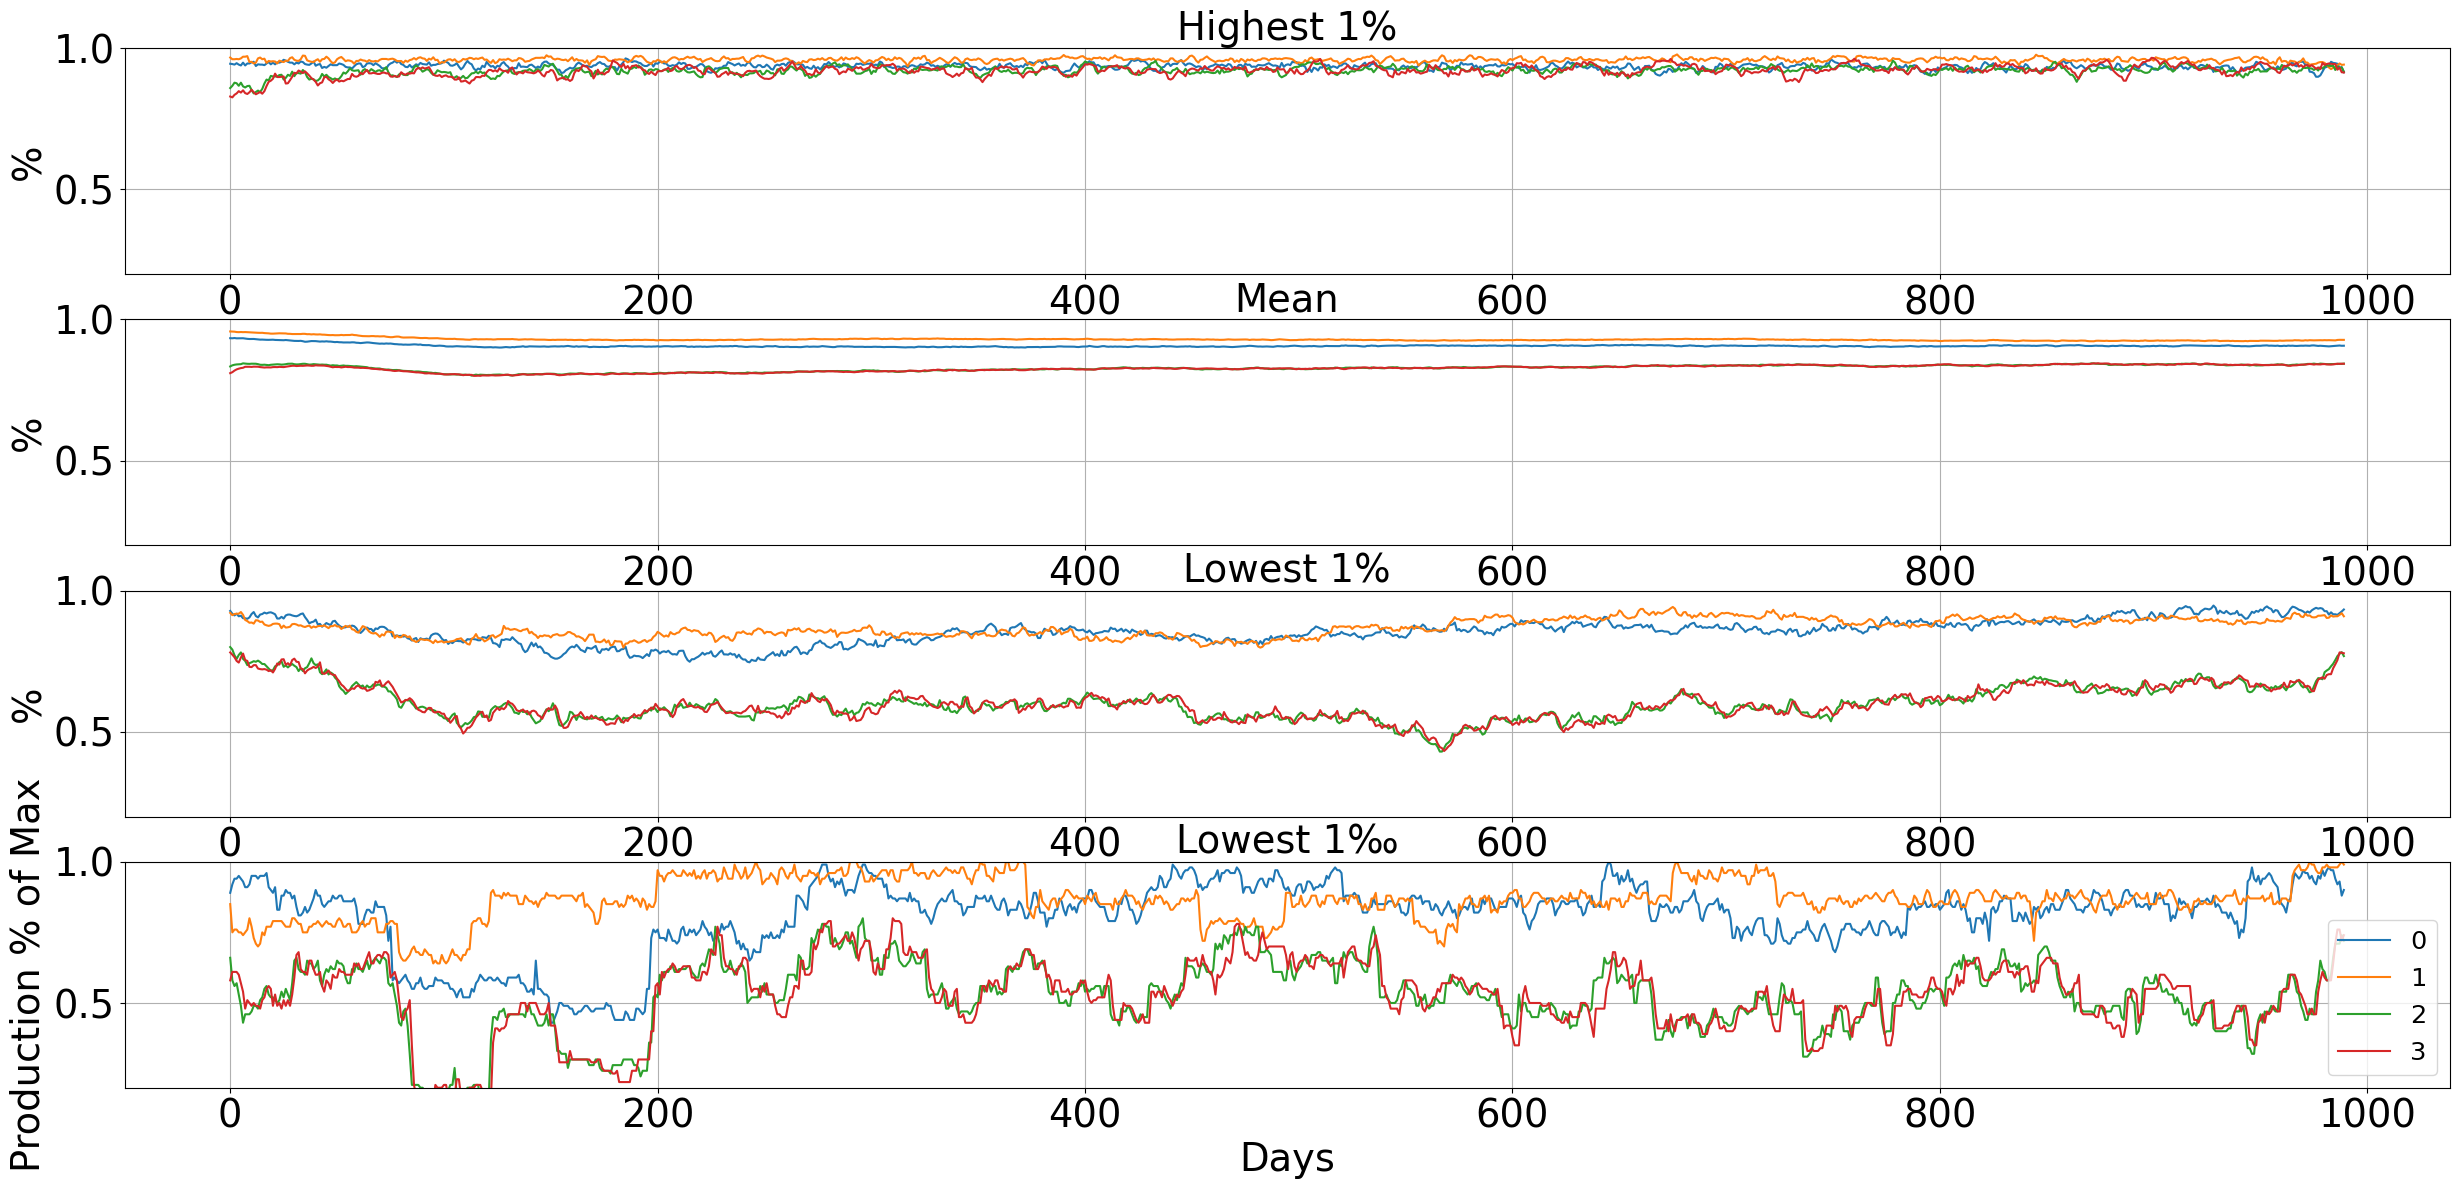

In [16]:
disaster = sorted.indices[:1]
topworst = sorted.indices[0:10]
topbest = sorted.indices[-10:]
worst = sorted.indices[0:100]
best = sorted.indices[-100:]

figsize = 30
height = figsize * 0.45
scale = (figsize*1.0) / 6.5
x_label_fontsize = 6 * scale
y_label_fontsize = 6 * scale
eq_fontsize = 11 * scale
legend = 4 * scale

worst_prod = th.mean(prod[:, worst, :], axis=1)[10:-1] / 10
best_prod = th.mean(prod[:, best, :], axis=1)[10:-1] / 10
topworst_prod = th.mean(prod[:, topworst, :], axis=1)[10:-1] / 10
topbest_prod = th.mean(prod[:, topbest, :], axis=1)[10:-1] / 10
disaster_prod = th.mean(prod[:, disaster, :], axis=1)[10:-1] / 10

fig, axs = plt.subplots(4, 1, figsize=(figsize, height))

for i in range(4):
    match i:
        case 0:
            axs[i].plot(best_prod[:, :], label=['A', 'B', 'C', 'D'])
            axs[i].set_ylabel('%', fontsize=y_label_fontsize)
            axs[i].set_ylim(0.20,1.0)
            axs[i].set_title('Highest 1%', fontsize=x_label_fontsize)
        case 1:
            axs[i].plot(mean_prod[:, :], label=['A', 'B', 'C', 'D'])
            axs[i].set_ylabel('%', fontsize=y_label_fontsize)
            axs[i].set_ylim(0.20,1.0)
            axs[i].set_title('Mean', fontsize=x_label_fontsize)
        case 2:
            axs[i].plot(worst_prod[:, :], label=['A', 'B', 'C', 'D'])
            axs[i].set_ylabel('%', fontsize=y_label_fontsize)
            axs[i].set_ylim(0.20,1.0)
            axs[i].set_title('Lowest 1%', fontsize=x_label_fontsize)
        case 3:
            axs[i].plot(topworst_prod[:, :], label=['0', '1', '2', '3'])
            axs[i].set_ylim(0.20, 1.0)
            axs[i].legend(loc='lower right', fontsize=legend)
            axs[i].set_ylabel('Production % of Max', fontsize=y_label_fontsize)
            axs[i].set_xlabel('Days', fontsize=x_label_fontsize)
            axs[i].set_title('Lowest 1‰', fontsize=x_label_fontsize)

    axs[i].tick_params(axis='y', labelsize=x_label_fontsize)
    axs[i].tick_params(axis='x', labelsize=y_label_fontsize)

    #axs[i].set_ylim(0.0, 1.1)
    axs[i].grid()


plt.show()

Storage
0


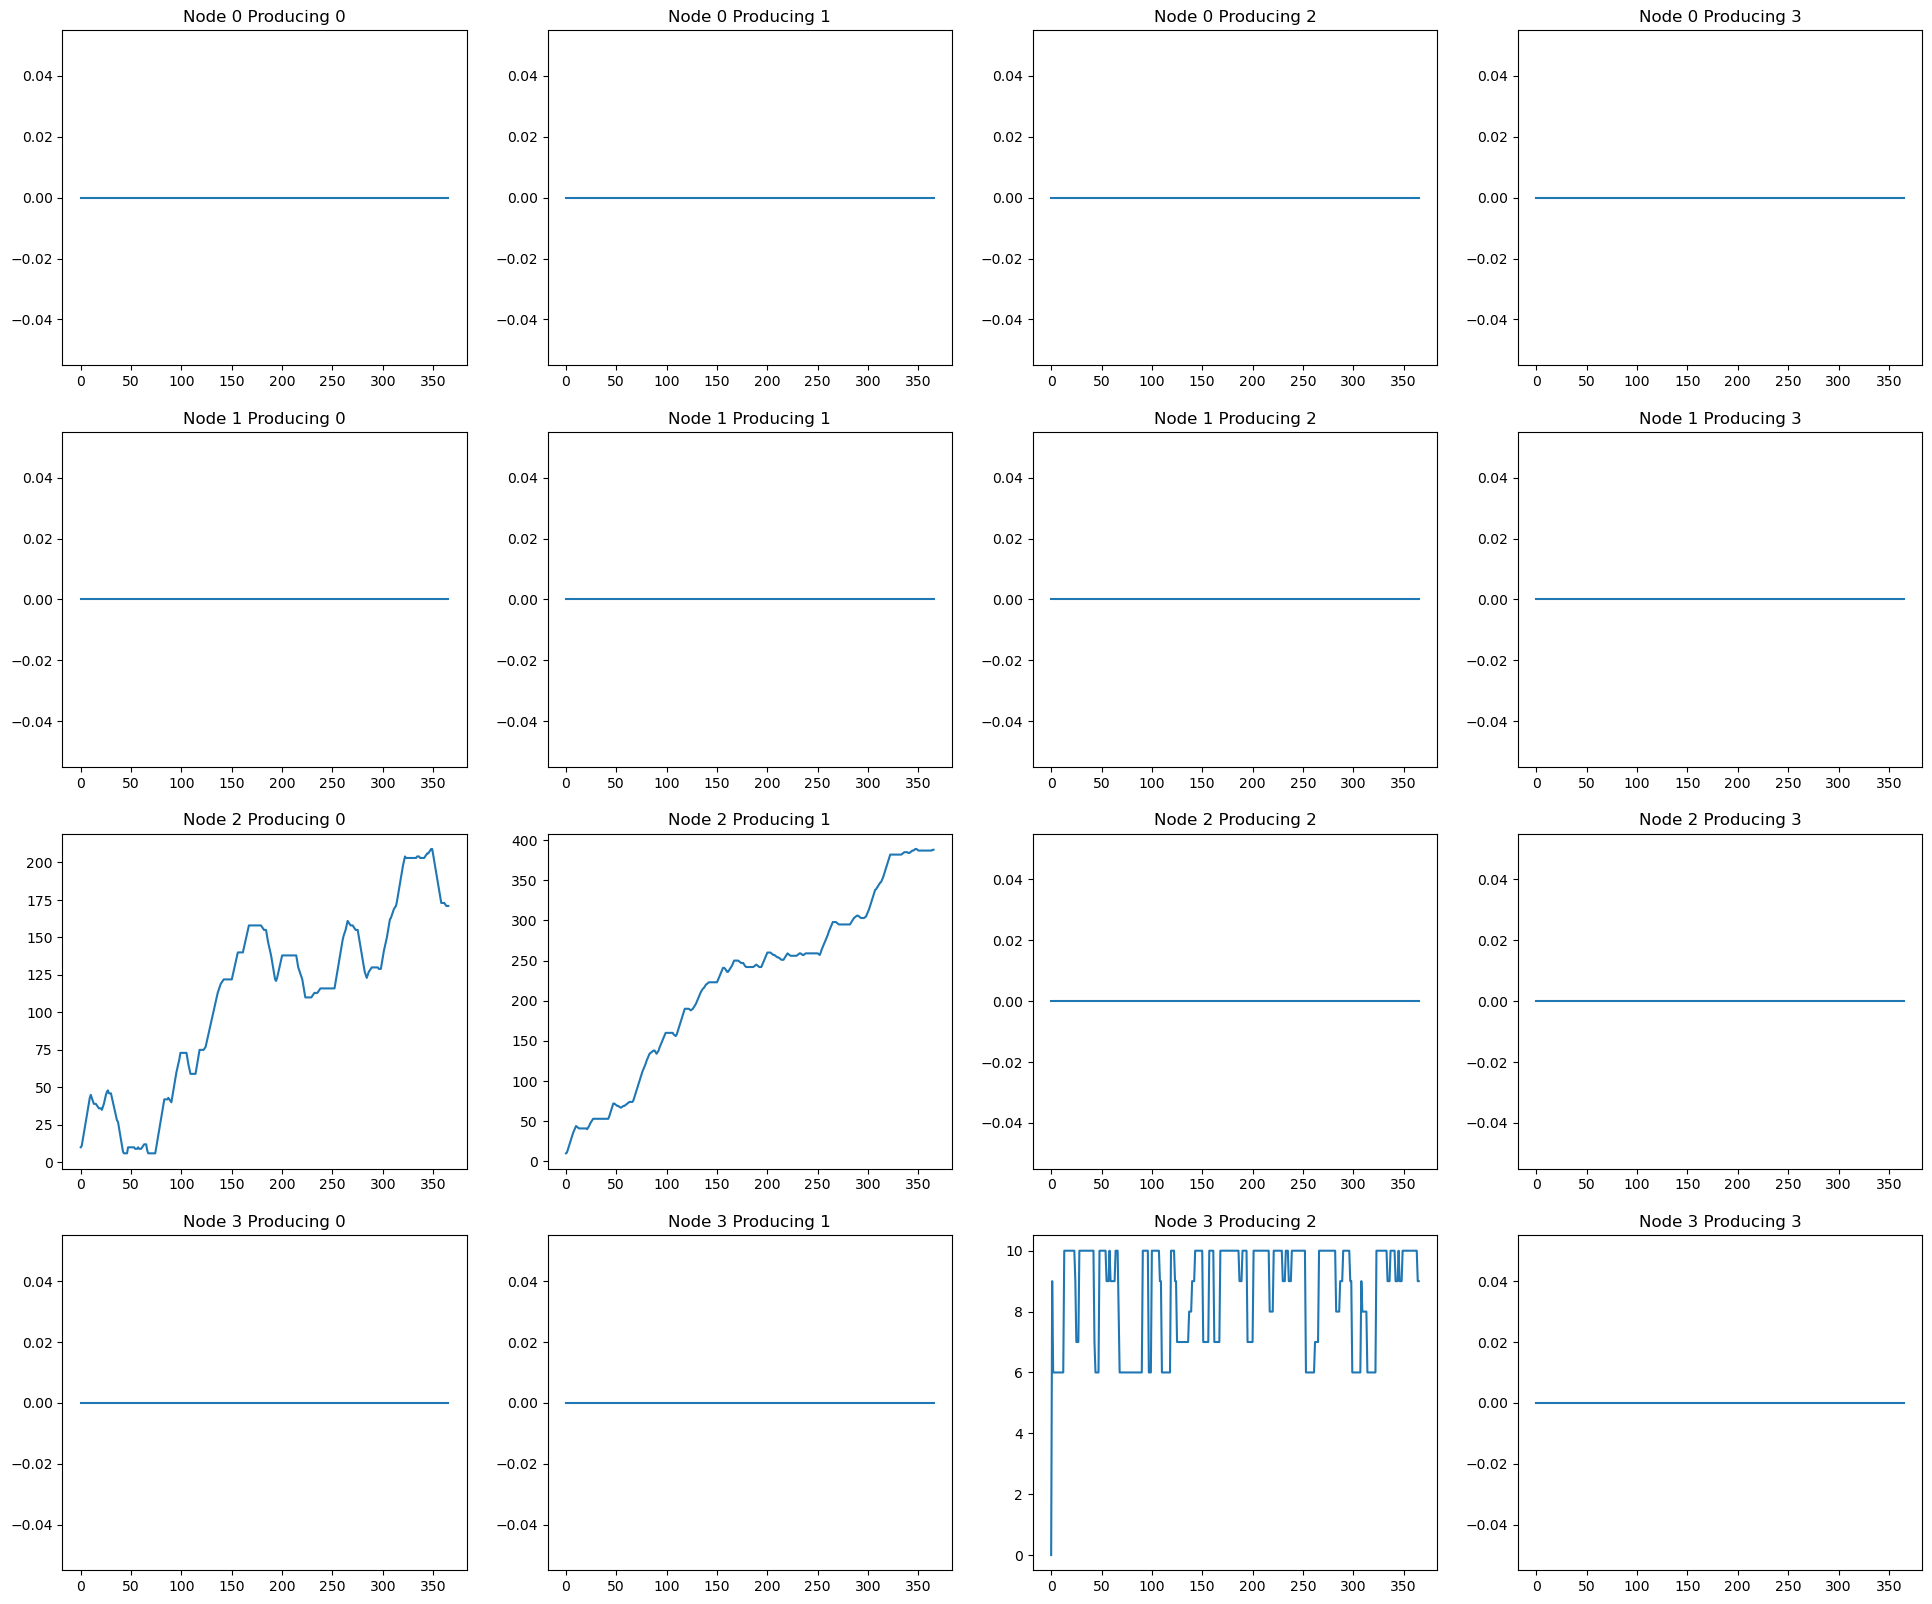

1


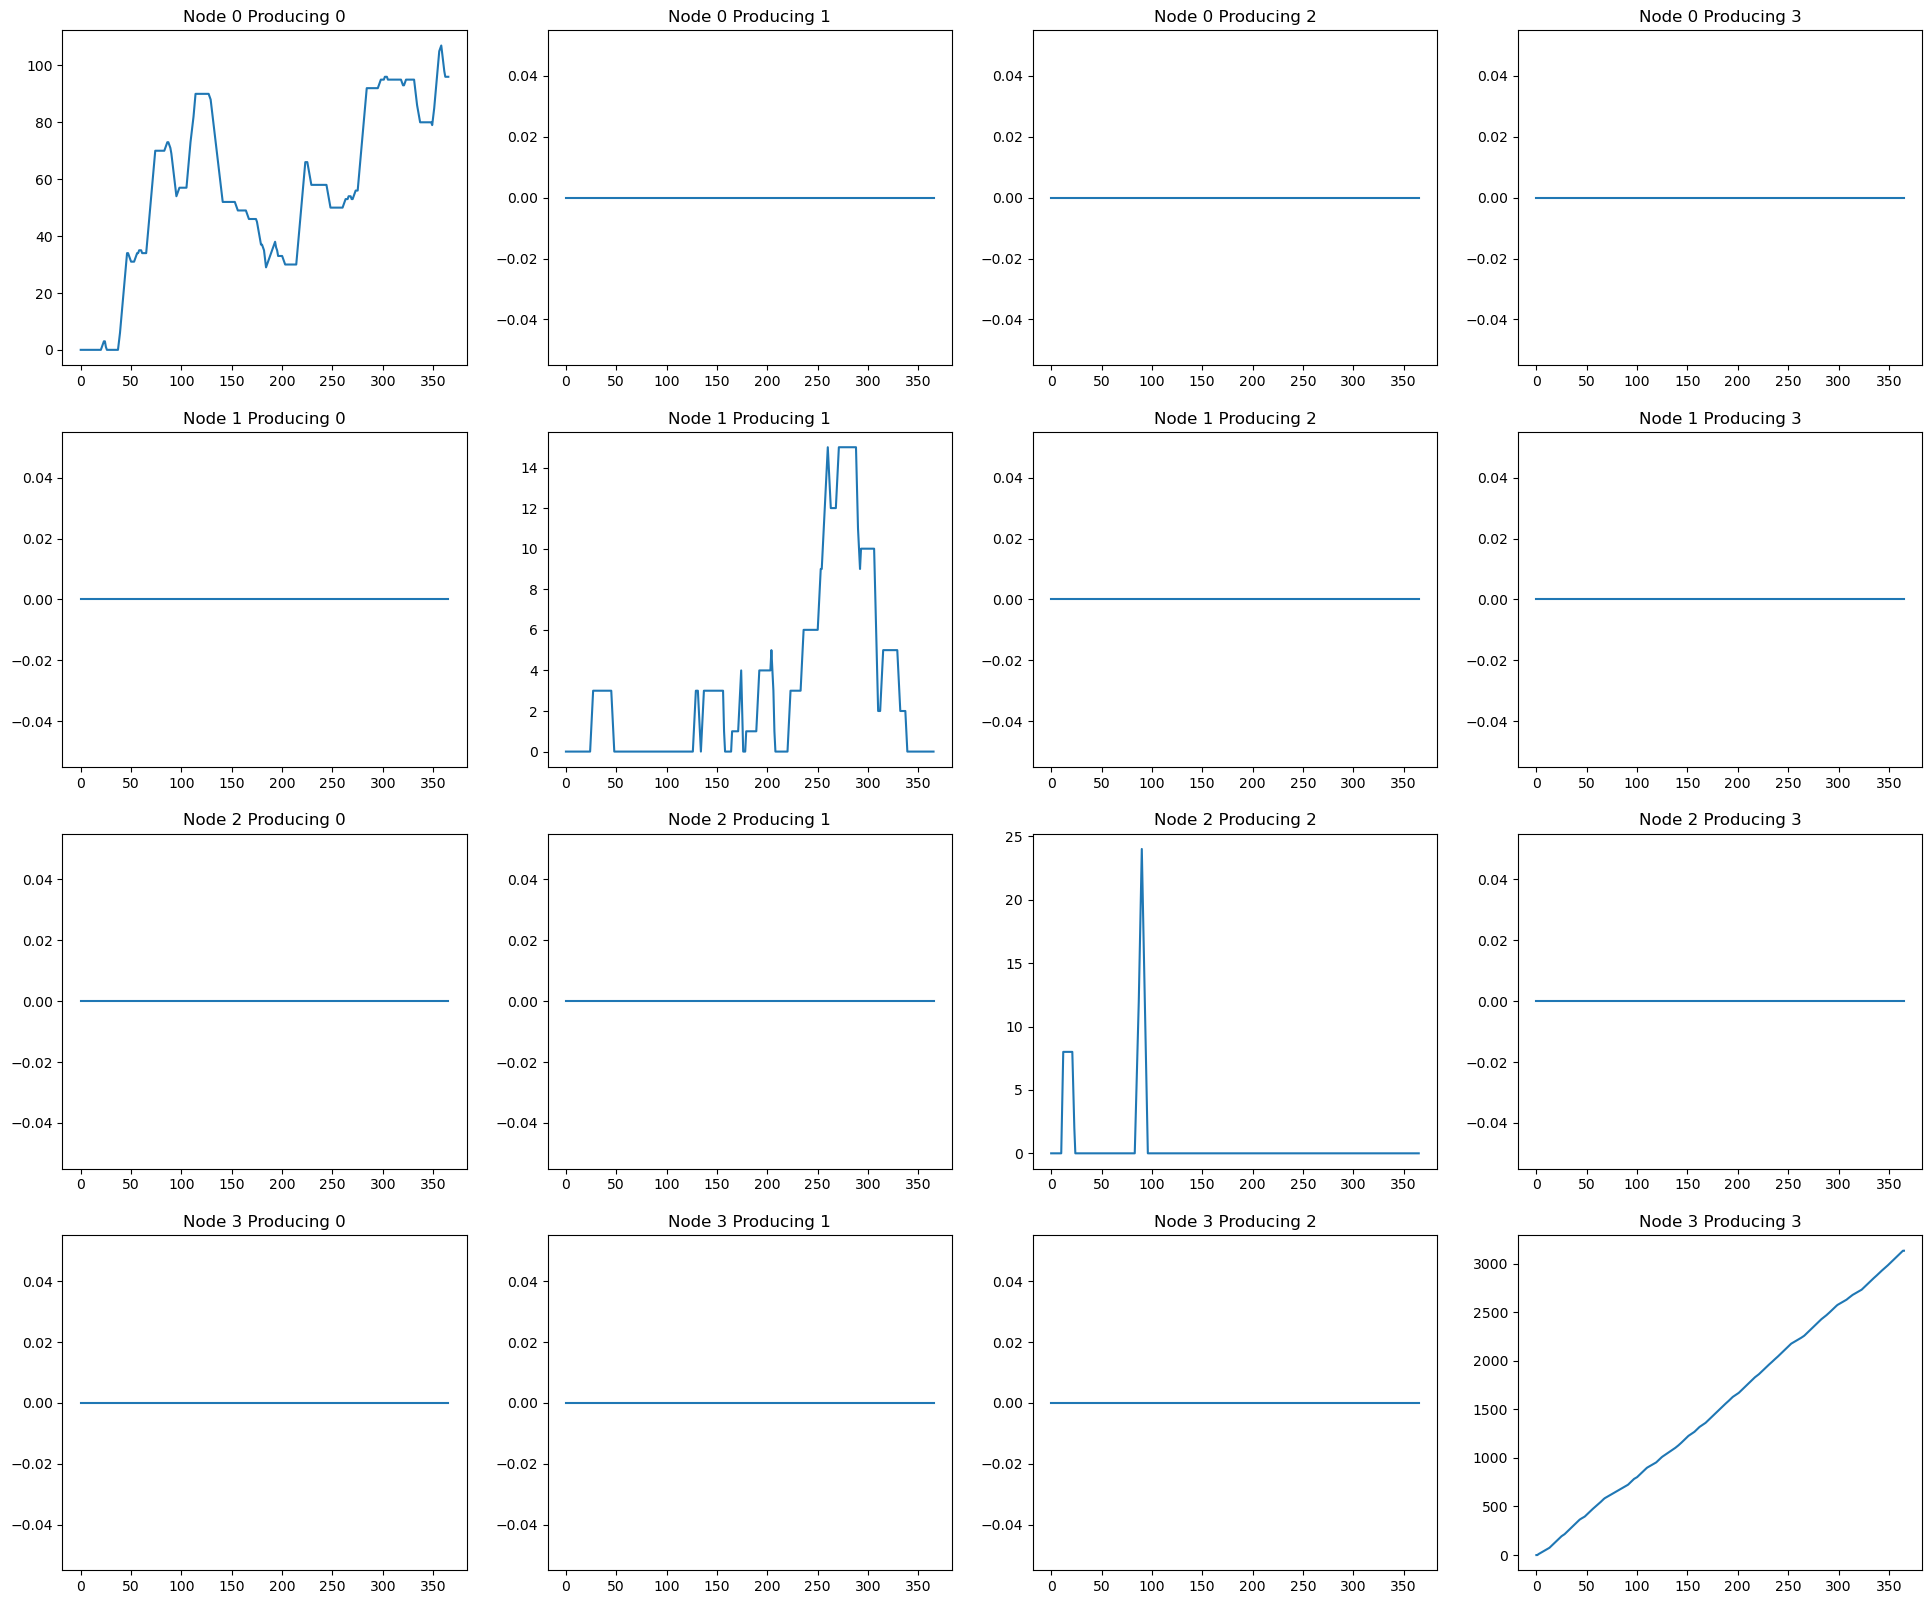

Production


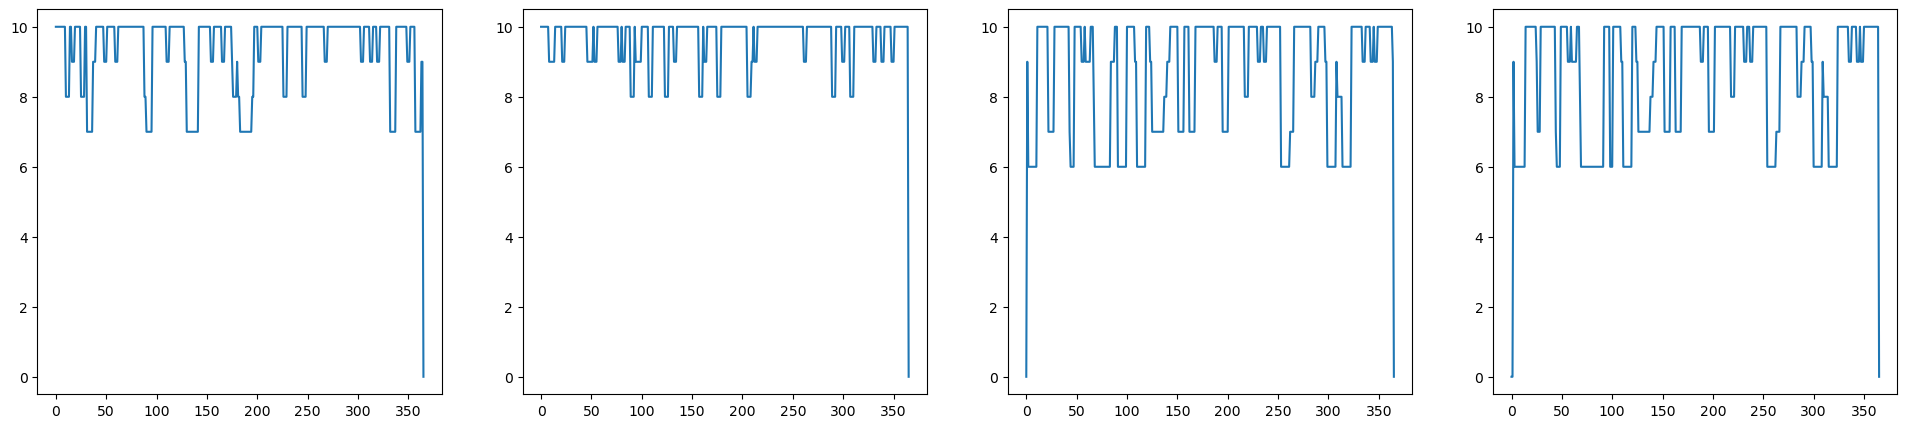

Transport


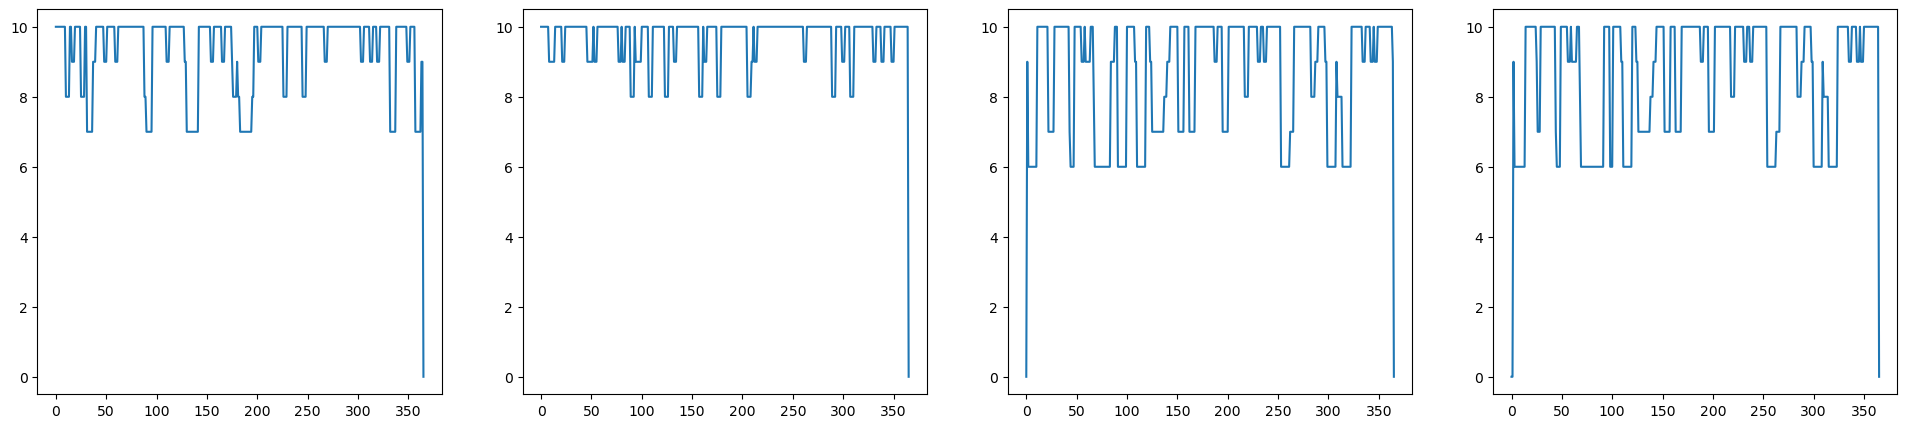

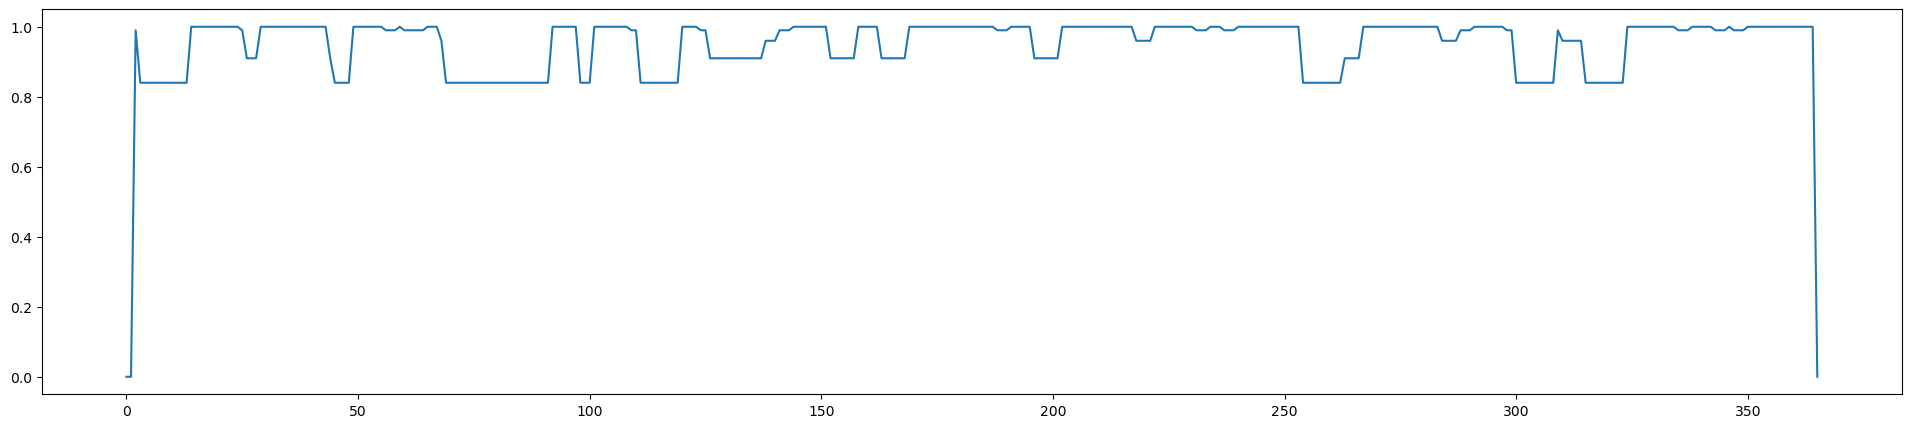

In [10]:
print('Storage')

for k in range(2):
    print(k)
    fig, axs = plt.subplots(inv.shape[-2], inv.shape[-1], figsize=(24, 20))
    for i in range(inv.shape[-2]):
        for j in range(inv.shape[-1]):
            axs[i, j].plot(inv[:, 0, k, i, j])
            axs[i, j].set_title("Node " + str(i) + ' Producing ' + str(j))

    plt.show()

print('Production')

fig, axs = plt.subplots(1, prod.shape[-1], figsize=(24, 5))

for i in range(prod.shape[-1]):
    axs[i].plot(prod[:, 0, i])

plt.show()

print('Transport')

fig, axs = plt.subplots(1, trans.shape[-1], figsize=(24, 5))

for i in range(trans.shape[-1]):
    axs[i].plot(trans[:, 0, i])

plt.show()

fig, axs = plt.subplots(1, 1, figsize=(24, 5))

axs.plot(loss[:, 0])

plt.show()